# Simple kriging in Python

This follows a tutorial and code by Connor Johnson, in [his blog post](http://connor-johnson.com/2014/03/20/simple-kriging-in-python/). It is openly licensed under the MIT license.

Some more geostatistics resources:

- More from Connor Johnson: https://github.com/cjohnson318/geostatsmodels
- Another library: https://github.com/whimian/pyGeoStatistics
- HPGL: https://github.com/hpgl/hpgl
- From Clayton Deutsch's lab: http://www.ccgalberta.com/pygeostat/welcome.html
- Following a scikit-learn API: https://pypi.python.org/pypi/scikit-gstat/0.1.6

## What is kriging?

Kriging is a set of techniques for interpolation. It differs from other interpolation techniques in that it sacrifices smoothness for the integrity of sampled points. Most interpolation techniques will over or undershoot the value of the function at sampled locations, but kriging honors those measurements and keeps them fixed.

## Data

We use the data from **Geoff Bohling** at the Kansas Geological Survey. [Click here](http://people.ku.edu/~gbohling/geostats/index.html) then look for "My tutorial on reservoir modeling...". I'm using the `ZoneA.dat` file.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, squareform
 
with open( '../data/ZoneA.dat', 'r') as f:
    z = f.readlines()
z = [ i.strip().split() for i in z[10:] ]
z = np.array( z, dtype=np.float )
z = pd.DataFrame( z, columns=['x', 'y', 'thk', 'por', 'perm', 'lperm', 'lpermp', 'lpermr'] )

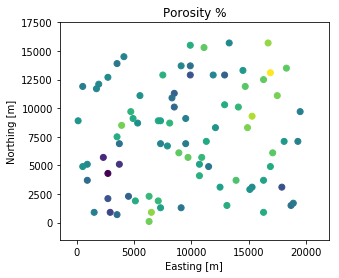

In [2]:
fig, ax = plt.subplots()
ax.scatter( z.x, z.y, c=z.por)
ax.set_aspect(1)
plt.xlim(-1500,22000)
plt.ylim(-1500,17500)
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.title('Porosity %')
plt.show()

## The semivariogram

According to Connor, these formulations follow Geoff Bohling's and Clayton Deutsch's work.

The semivariogram encodes data about spatial variance over the region at a given distance or lag. We generally expect data points that are close together spatially to share other characteristics, and we expect points that are separated by greater distances to have lesser correlation. The semivariogram allows us to model the similarity points in a field as a function of distance. The semivariogram is given by,

$$ \hat{\gamma}(h) = \dfrac{1}{2N(h)} \displaystyle \sum_{N(h)} ( z_{i} - z_{j} )^{2} $$

Here, h is distance specified by the user, and z_{i} and z_{j} are two points that are separated spatially by h. The N(h) term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance h. As an aside, contrast this with the formulation for variance,

$$ s = \dfrac{1}{N-1} \displaystyle \sum_{k=1}^{N} (z_{k} - \hat{\mu} )^{2} $$ 

Here, $N$ is the number of data points, $\hat{\mu}$ is the sample mean, and $z_{k}$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance $h$. We can write some functions to calculate the semivariogram at one lag, and then at multiple lags as follows.

In [3]:
def SVh(P, h, bw):
    '''
    Experimental semivariogram for a single lag.
    '''
    dists = squareform(pdist(P[:,:2]))
    N = dists.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( dists[i,j] >= h-bw )and( dists[i,j] <= h+bw ):
                Z.append(( P[i,2] - P[j,2])**2)
    return np.sum(Z) / (2.0 * len( Z ))
 
def SV(P, hs, bw):
    '''
    Experimental variogram for a collection of lags.
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

The C() function is the covariance function, and will be used later. Let us now calculate and plot the semivariogram,

In [4]:
def C(P, h, bw):
    '''
    Calculate the sill.
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

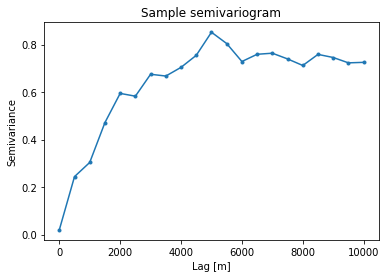

In [5]:
# Part of our data set recording porosity.
P = np.array(z[['x', 'y', 'por']])

# Bandwidth, plus or minus 250 meters.
bw = 500

# Lags in 500 meter increments from zero to 10,000.
hs = np.arange(0, 10500, bw)
sv = SV( P, hs, bw )

# Make a plot.
plt.plot( sv[0], sv[1], '.-' )
plt.xlabel('Lag [m]')
plt.ylabel('Semivariance')
plt.title('Sample semivariogram') ;
plt.show()

## Modeling

Now that we’ve calculated the semivariogram, we will need to fit a model to the data. There are three popular models, the spherical, exponential, and the Gaussian. Here, we’ll implement the spherical model. First, we will present a function named opt() for determining the optimal value a for the spherical model.

In [6]:
def opt(func, x, y, C0, parameterRange=None, meshSize=1000):
    if parameterRange == None:
        parameterRange = [x[1], x[-1]]
    mse = np.zeros(meshSize)
    a = np.linspace(parameterRange[0], parameterRange[1], meshSize)
    for i in range(meshSize):
        mse[i] = np.mean((y - func(x, a[i], C0))**2.0)
    return a[mse.argmin()]

The opt() function finds the optimal parameter for fitting a spherical model to the semivariogram data. The spherical model is given by the function spherical(). On the last line we see that spherical() returns itself in a map() function, which seems odd. The idea is that the input h can be a single float value, or list or NumPy array of floats. If h is a single value, then line 9 is called. If h is a list or an array (an iterable) then line 17 is called, which applies line 9 to each value of h.

In [7]:
def spherical(h, a, C0):
    '''
    Spherical model of the semivariogram
    '''
    # If h is a scalar:
    if np.ndim(h) == 0:
        # Calculate the spherical function.
        if h <= a:
            return C0 * ( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    else:
        # Calculate the spherical function for all elements.
        a = np.ones(h.size) * a
        C0 = np.ones(h.size) * C0
        return np.array(list(map(spherical, h, a, C0)))

Next, `cvmodel()` fits a model to the semivariogram data and returns a covariance method named `covfct()`.

In [8]:
def cvmodel(P, model, hs, bw):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # Calculate the semivariogram.
    sv = SV(P, hs, bw)
    # Calculate the sill.
    C0 = C(P, hs[0], bw)
    # Calculate the optimal parameters.
    param = opt(model, sv[0], sv[1], C0)
    # Return a covariance function.
    return lambda h, a=param: C0 - model(h, a, C0)

At this point we’ll plot our model and see if it represents our data well.

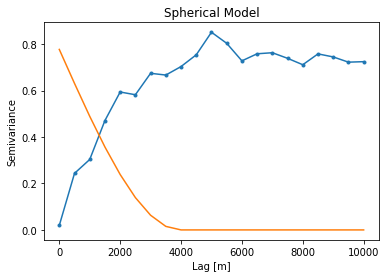

In [9]:
sp = cvmodel(P, model=spherical, hs=np.arange(0, 10500, 500), bw=500)

plt.plot( sv[0], sv[1], '.-' )
plt.plot( sv[0], sp( sv[0] ) ) ;
plt.title('Spherical Model')
plt.ylabel('Semivariance')
plt.xlabel('Lag [m]')
plt.show()

## Kriging

Now that we have a model for the semivariogram, we can write a function to perform the kriging. The fundamental relationship is a matrix equation,

$$ K \lambda = k \Rightarrow \lambda = K^{-1} k $$

Here, $K$ is a matrix of covariances calculated using the spherical model, $\lambda$ is a vector of simple kriging weights, and $k$ is the vector of covariances between the data points and an unsampled point. Our kriging function takes the data set `P`, the `model`, the distances `hs`, the bandwidth `bw`, the coordinates of the unsampled point `u`, and the number of surrounding points `N` to use in the calculation.

In [10]:
def krige(P, model, hs, bw, u, N):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
 
    # covariance function
    covfct = cvmodel(P, model, hs, bw)
    # mean of the variable
    mu = np.mean(P[:,2])
 
    # distance between u and each data point in P
    d = np.sqrt((P[:,0]-u[0])**2.0 + (P[:,1]-u[1])**2.0)
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

## Estimation

Here, we’ll calculate the kriging estimate at a number of unsampled points.

In [18]:
P[:,0].min(), P[:,0].max(), P[:,1].min(), P[:,1].max()

(100.0, 19500.0, 100.0, 15700.0)

In [11]:
X0, X1 = 0, 20000
Y0, Y1 = 0, 16000

# Define the number of grid cells over which to make estimates.
# TODO: Vectorize this. I'll try numba/jit but I don't think it'll help.
# I think it can be vectorized with np.mgrid (better than np.meshgrid)

# Many points:
x, y = 100, 80

# Fewer points:
x, y = 50, 40

dx, dy = (X1-X0) / x, (Y1-Y0) / y

def stepwise(x, y):
    Z = np.zeros((y, x))
    
    for i in range(y):
        print(i, end=' ')
        for j in range(x):
            Z[i, j] = krige(P, model=spherical, hs=hs, bw=bw, u=(dy*j, dx*i), N=16)
            
    return Z

In [15]:
# THIS IS SLOW
# Z = stepwise(x, y)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [16]:
Z

array([[ 14.68508649,  14.61324556,  14.52194962, ...,  14.6098204 ,
         14.55899146,  14.54633814],
       [ 14.66916901,  14.59340954,  14.50050148, ...,  14.48677469,
         14.44159051,  14.44559628],
       [ 14.64478501,  14.56652456,  14.47714881, ...,  14.33014127,
         14.28201508,  14.3159636 ],
       ..., 
       [ 14.6012807 ,  14.57365856,  14.54014377, ...,  15.67013665,
         15.42526252,  15.18910961],
       [ 14.64117585,  14.6178897 ,  14.58622709, ...,  15.60850187,
         15.3722216 ,  15.14385357],
       [ 14.67200929,  14.65368008,  14.62580482, ...,  15.53882965,
         15.30873613,  15.08625655]])

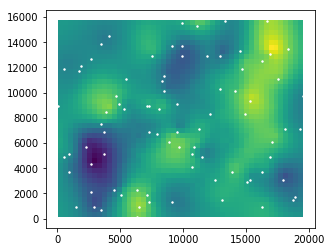

In [24]:
extent = [X0, X1, Y0, Y1]

plt.imshow(Z, origin='lower', interpolation='none', extent=extent)
plt.scatter(z.x, z.y, s=2, c='w')
 
plt.show()

## Comparison to 2D Gaussian process regression

This needs writing.

https://stackoverflow.com/questions/41572058/how-to-correctly-use-scikit-learns-gaussian-process-for-a-2d-inputs-1d-output/43409379